In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import MaxPool2D

# Dataset

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


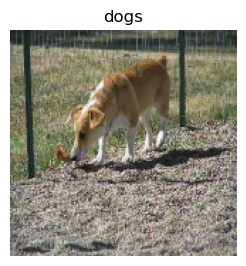

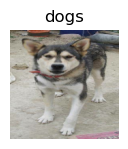

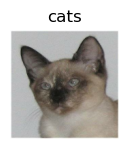

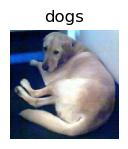

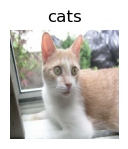

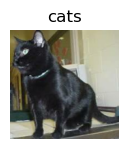

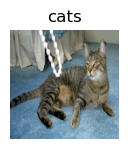

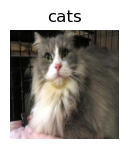

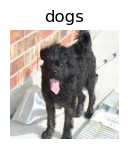

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.show()

In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset) #nb of batches of data are available in the validation ds
test_dataset = validation_dataset.take(val_batches // 5) #we move 20% of them to a test set
validation_dataset = validation_dataset.skip(val_batches // 5)

In [5]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE) 
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input
#convert the input images from RGB to BGR,
#then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

In [8]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
#Multiply inputs by scale and adds offset.

In [9]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 512)


In [11]:
base_model.trainable = True

In [12]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


In [13]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [15]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [16]:
inputs = tf.keras.Input(shape=(160, 160, 3))
#x = data_augmentation(inputs)
x = inputs
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 160, 160, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513   

In [19]:
len(model.trainable_variables)

14

In [20]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 56s 2s/step - loss: 2.6437 - accuracy: 0.6325


In [21]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.77
initial accuracy: 0.62


In [22]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 174s 3s/step - loss: 0.5713 - accuracy: 0.8680 - val_loss: 0.1681 - val_accuracy: 0.9431
Epoch 2/10
63/63 [==============================] - 171s 3s/step - loss: 0.0917 - accuracy: 0.9635 - val_loss: 0.1321 - val_accuracy: 0.9493
Epoch 3/10
63/63 [==============================] - 174s 3s/step - loss: 0.0388 - accuracy: 0.9860 - val_loss: 0.1003 - val_accuracy: 0.9678
Epoch 4/10
63/63 [==============================] - 176s 3s/step - loss: 0.0267 - accuracy: 0.9930 - val_loss: 0.1746 - val_accuracy: 0.9480
Epoch 5/10
63/63 [==============================] - 180s 3s/step - loss: 0.0137 - accuracy: 0.9945 - val_loss: 0.1018 - val_accuracy: 0.9678
Epoch 6/10
63/63 [==============================] - 186s 3s/step - loss: 0.0085 - accuracy: 0.9980 - val_loss: 0.0919 - val_accuracy: 0.9715
Epoch 7/10
63/63 [==============================] - 192s 3s/step - loss: 0.0026 - accuracy: 0.9990 - val_loss: 0.1223 - val_accuracy: 0.9678
Epoch 8/10
63

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

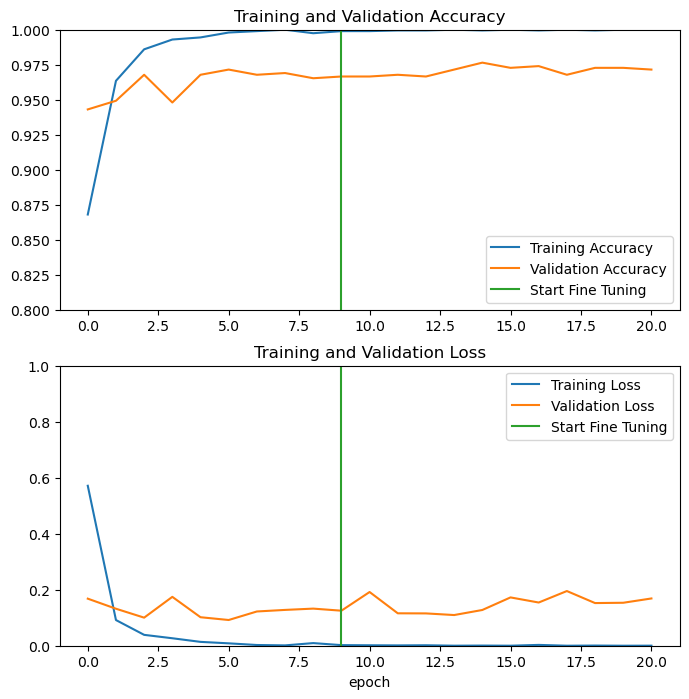

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 6s 1s/step - loss: 0.1698 - accuracy: 0.9688
Test accuracy : 0.96875


In [26]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Predictions:
 [0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0]
Labels:
 [0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0]
